In [1]:
from Binaries import *

HardwareClassifier                            full_random_traces_downsampled...    176394       0       0 1827324 -> ACC =   8.80%


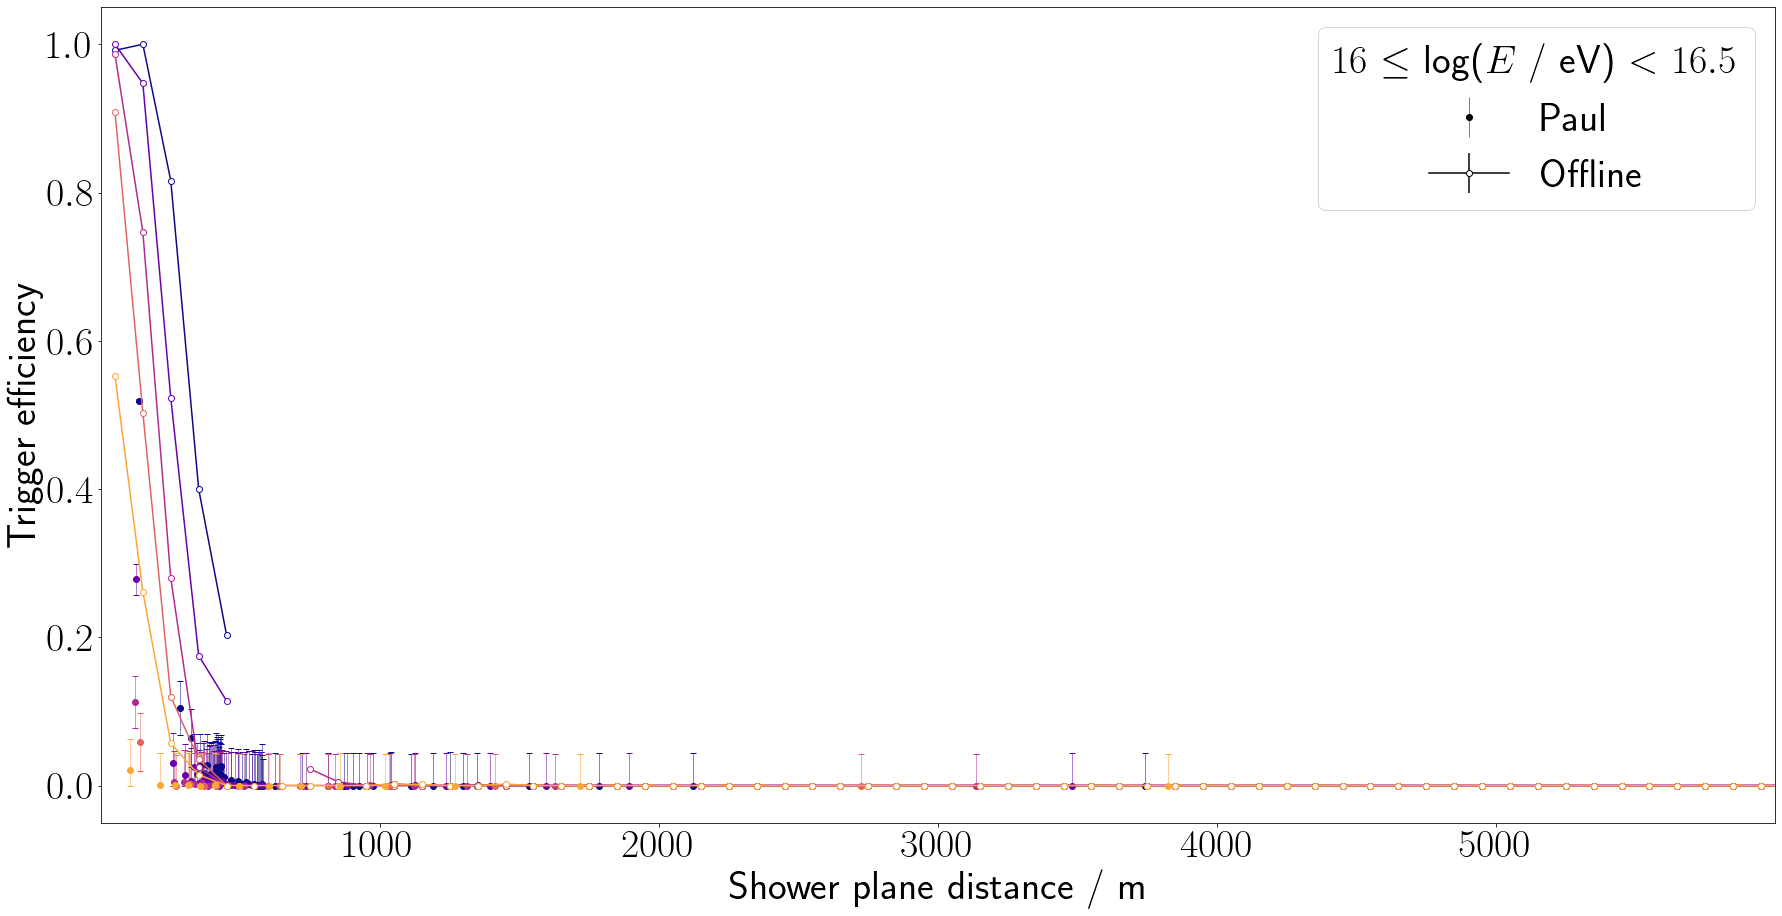

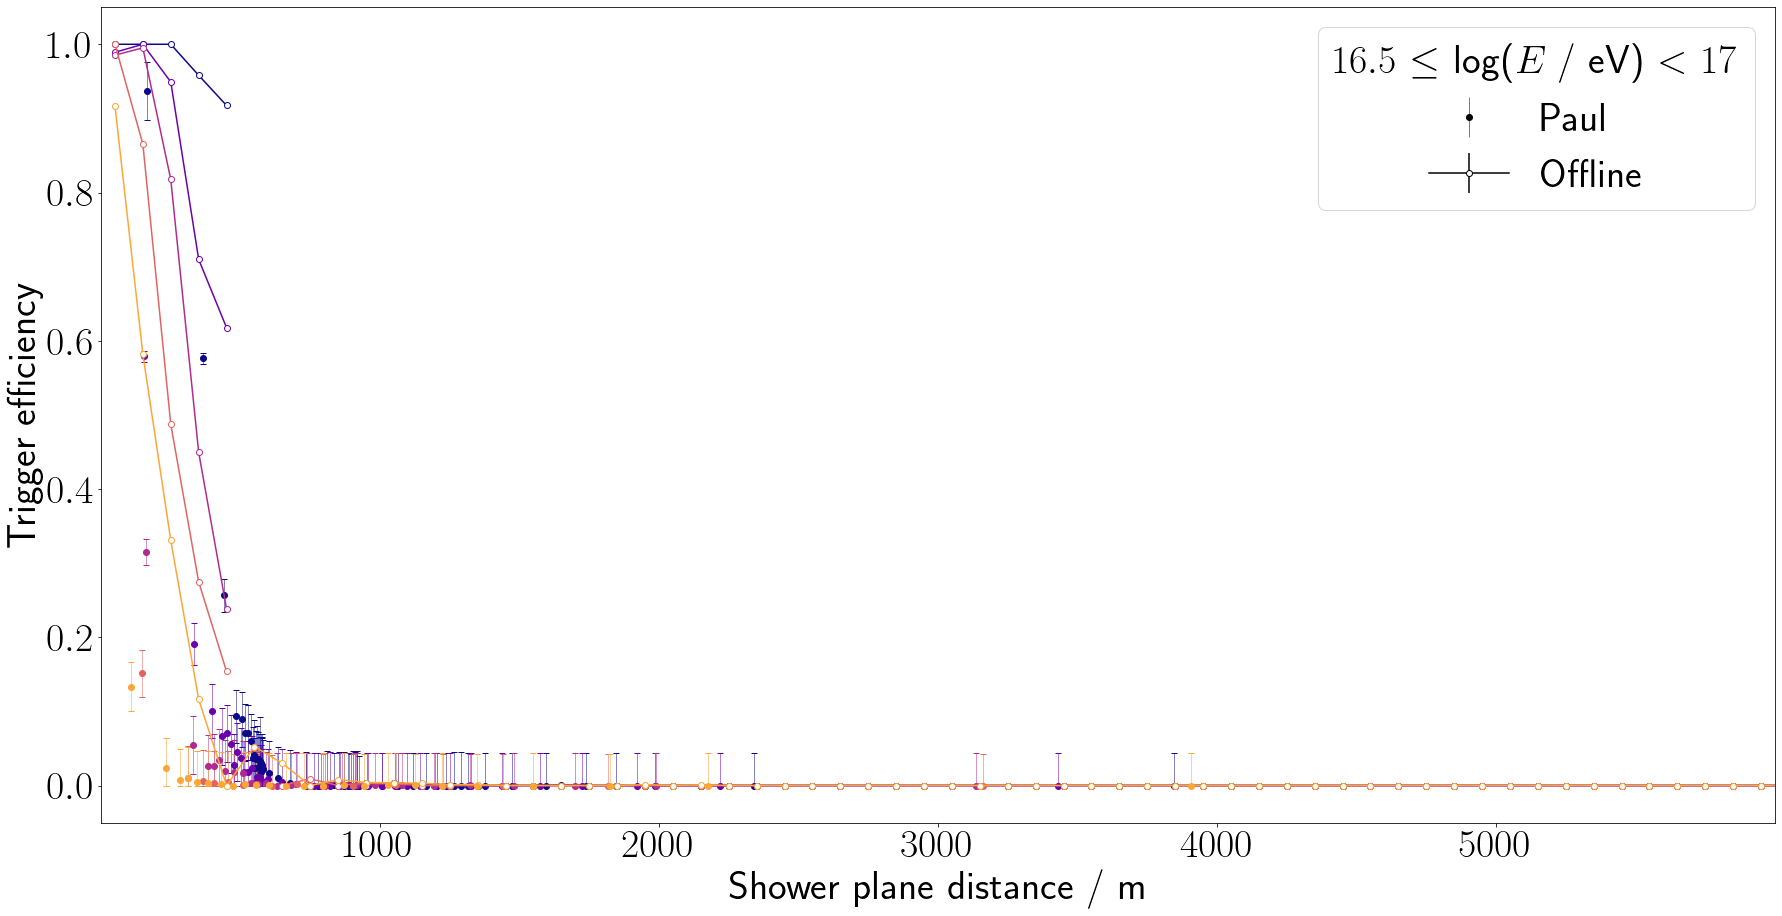

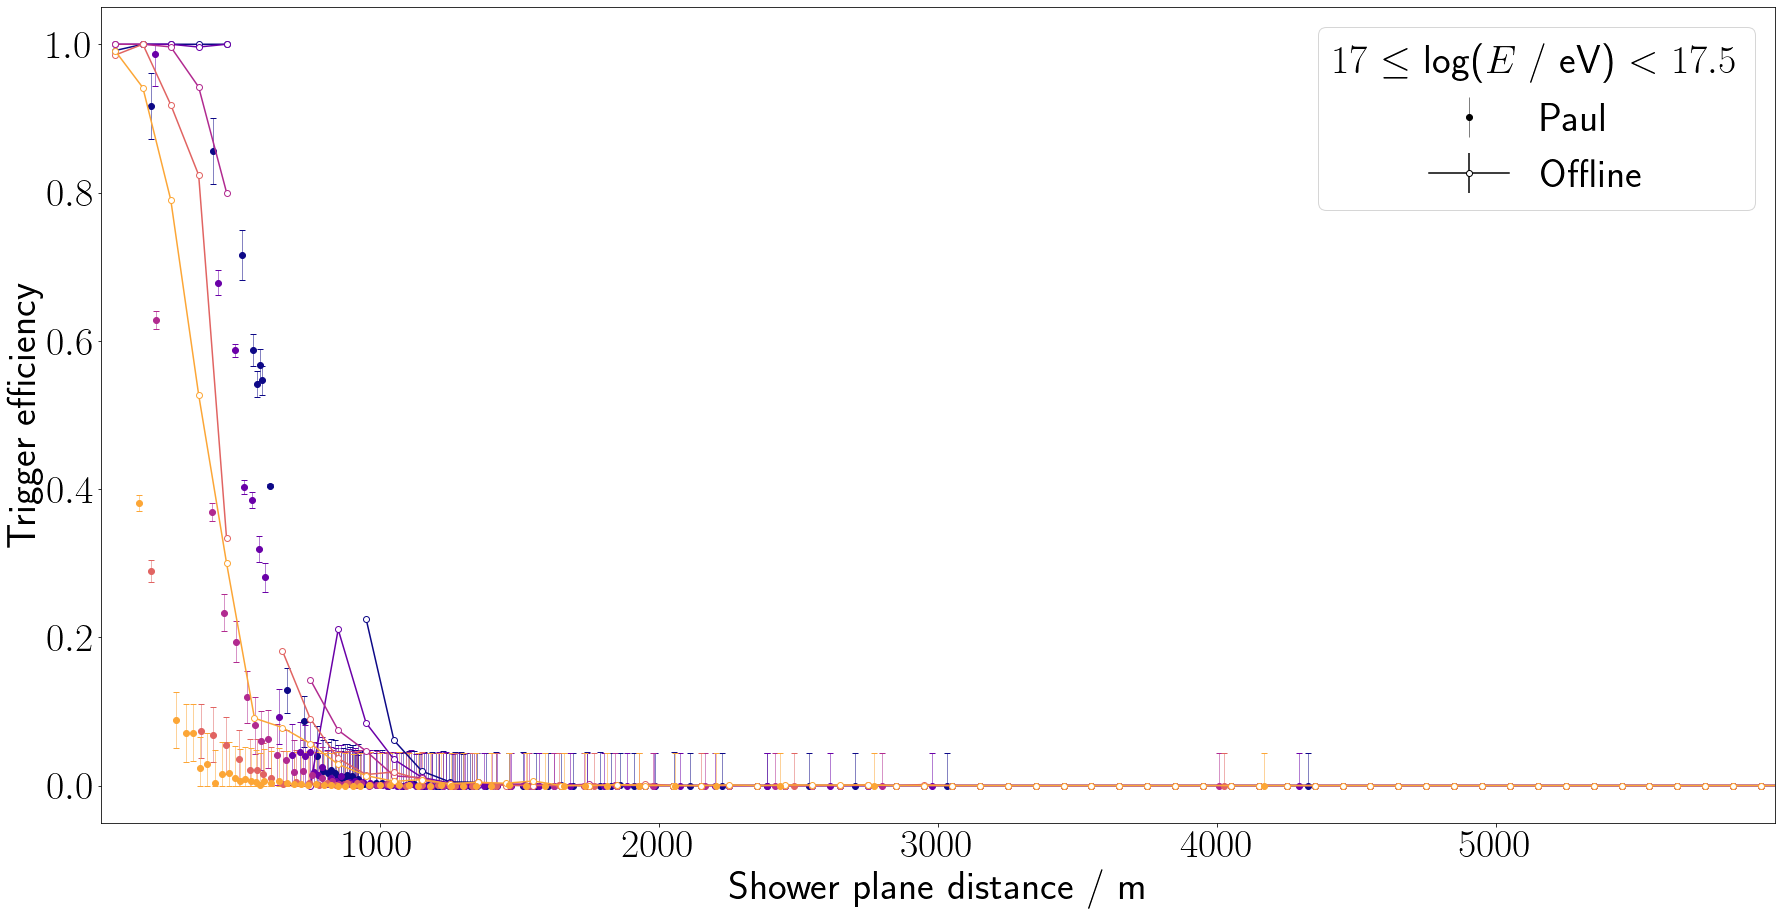

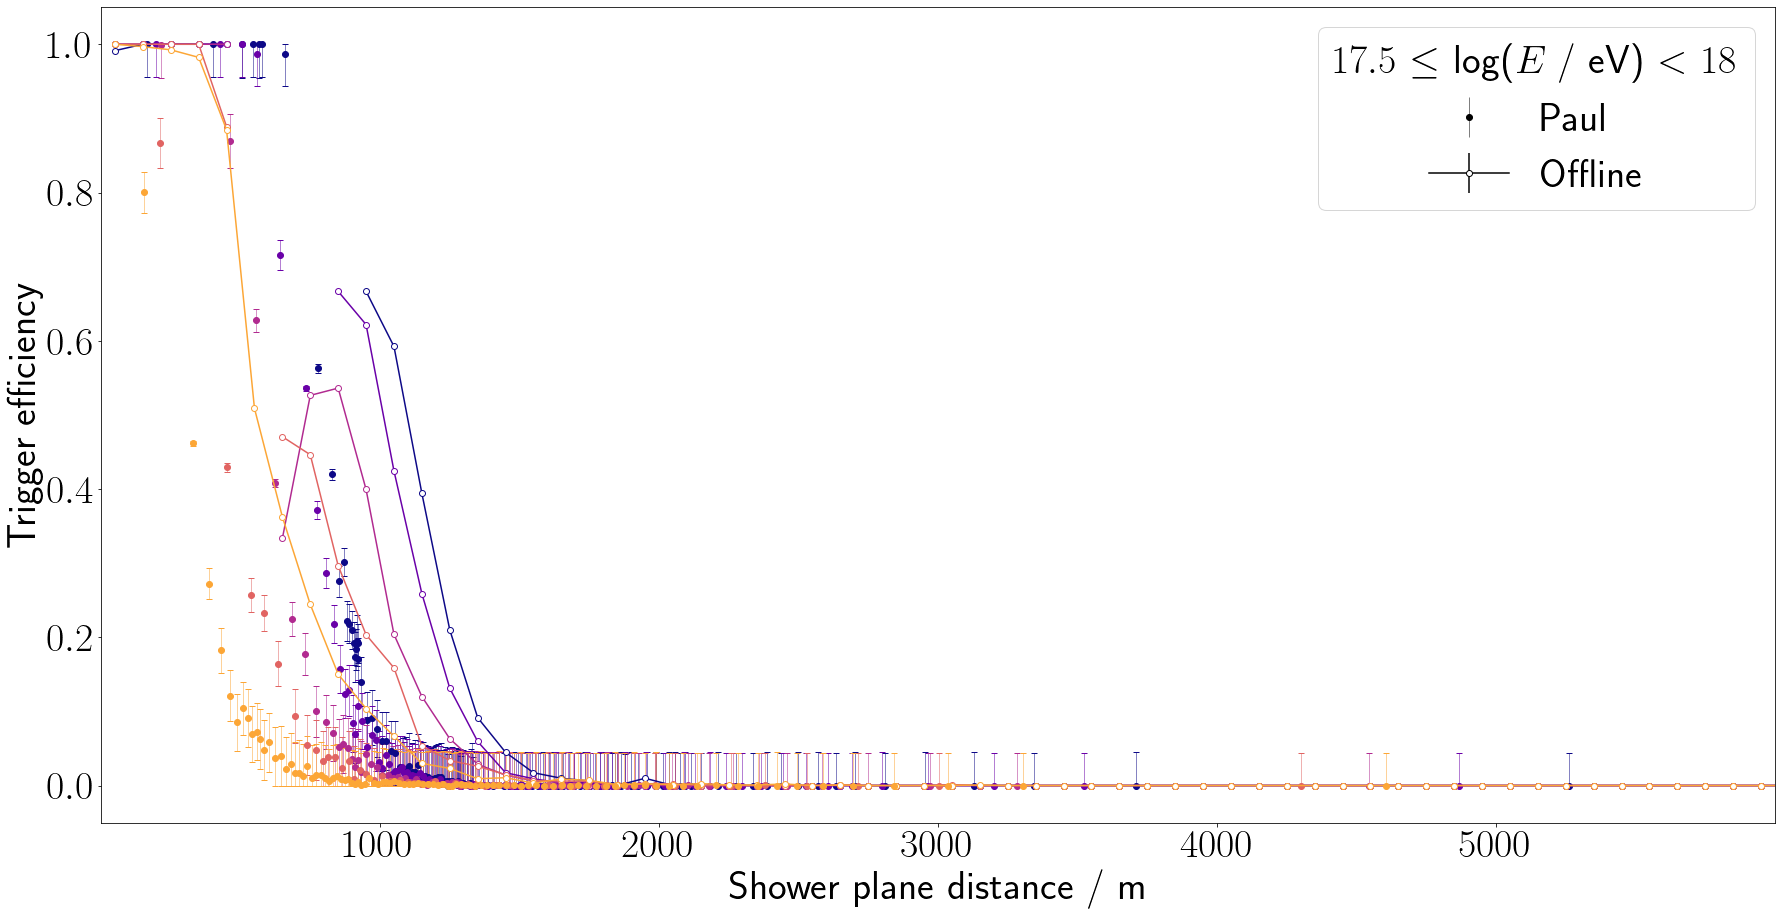

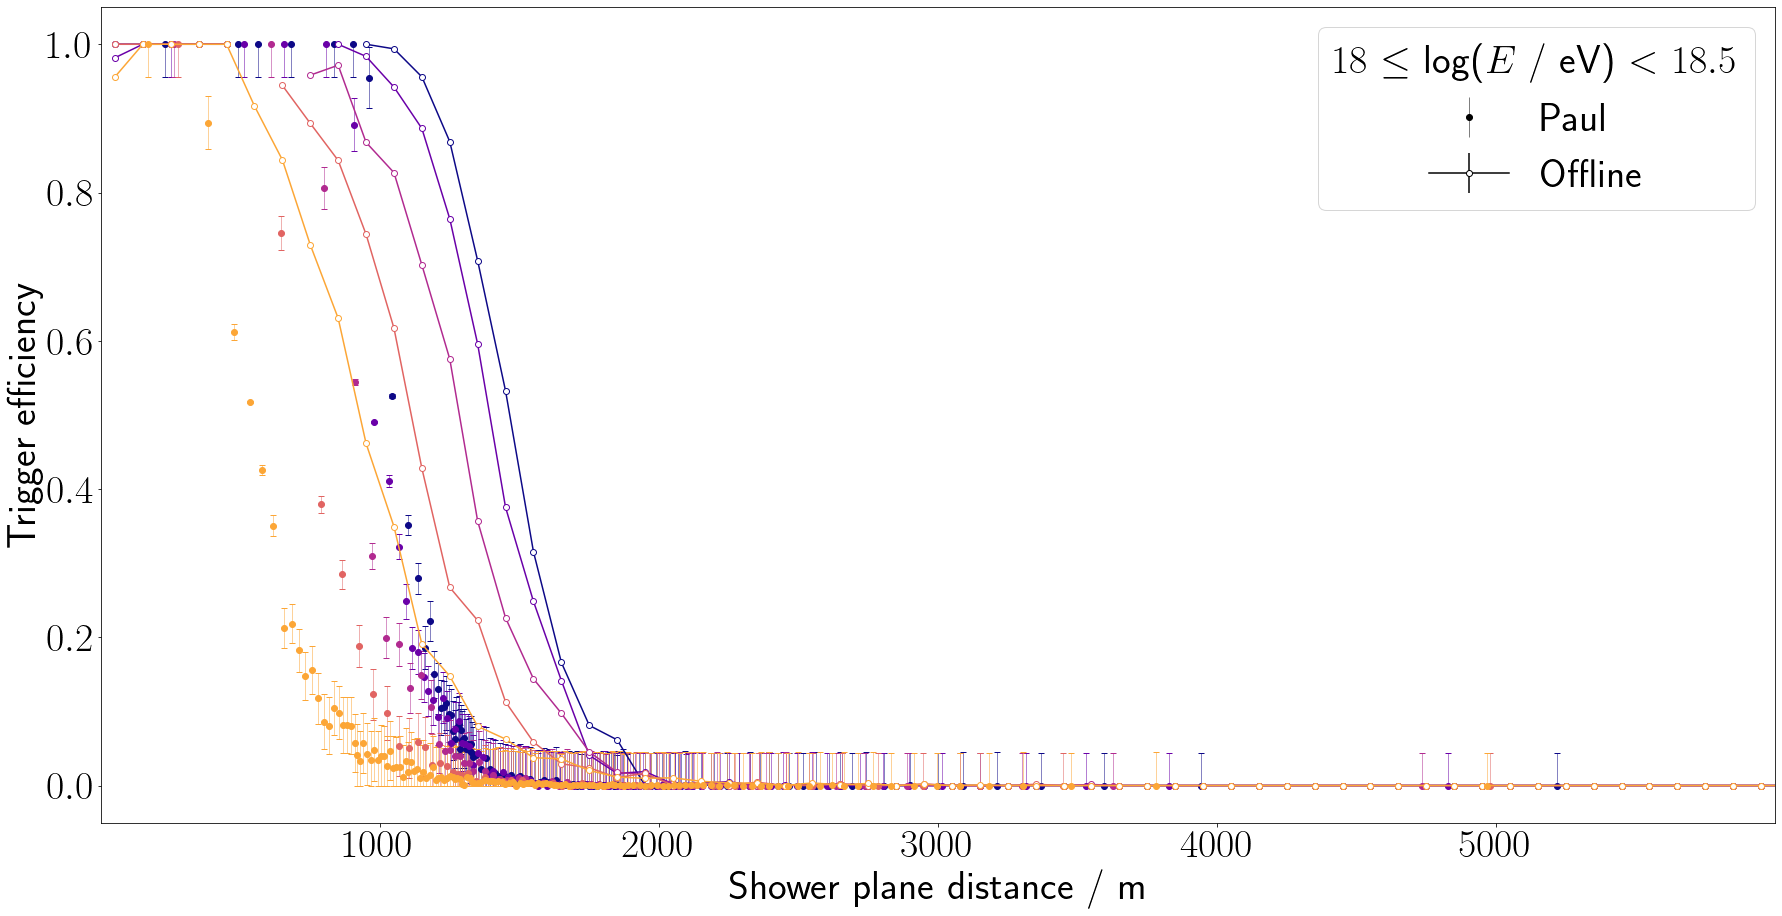

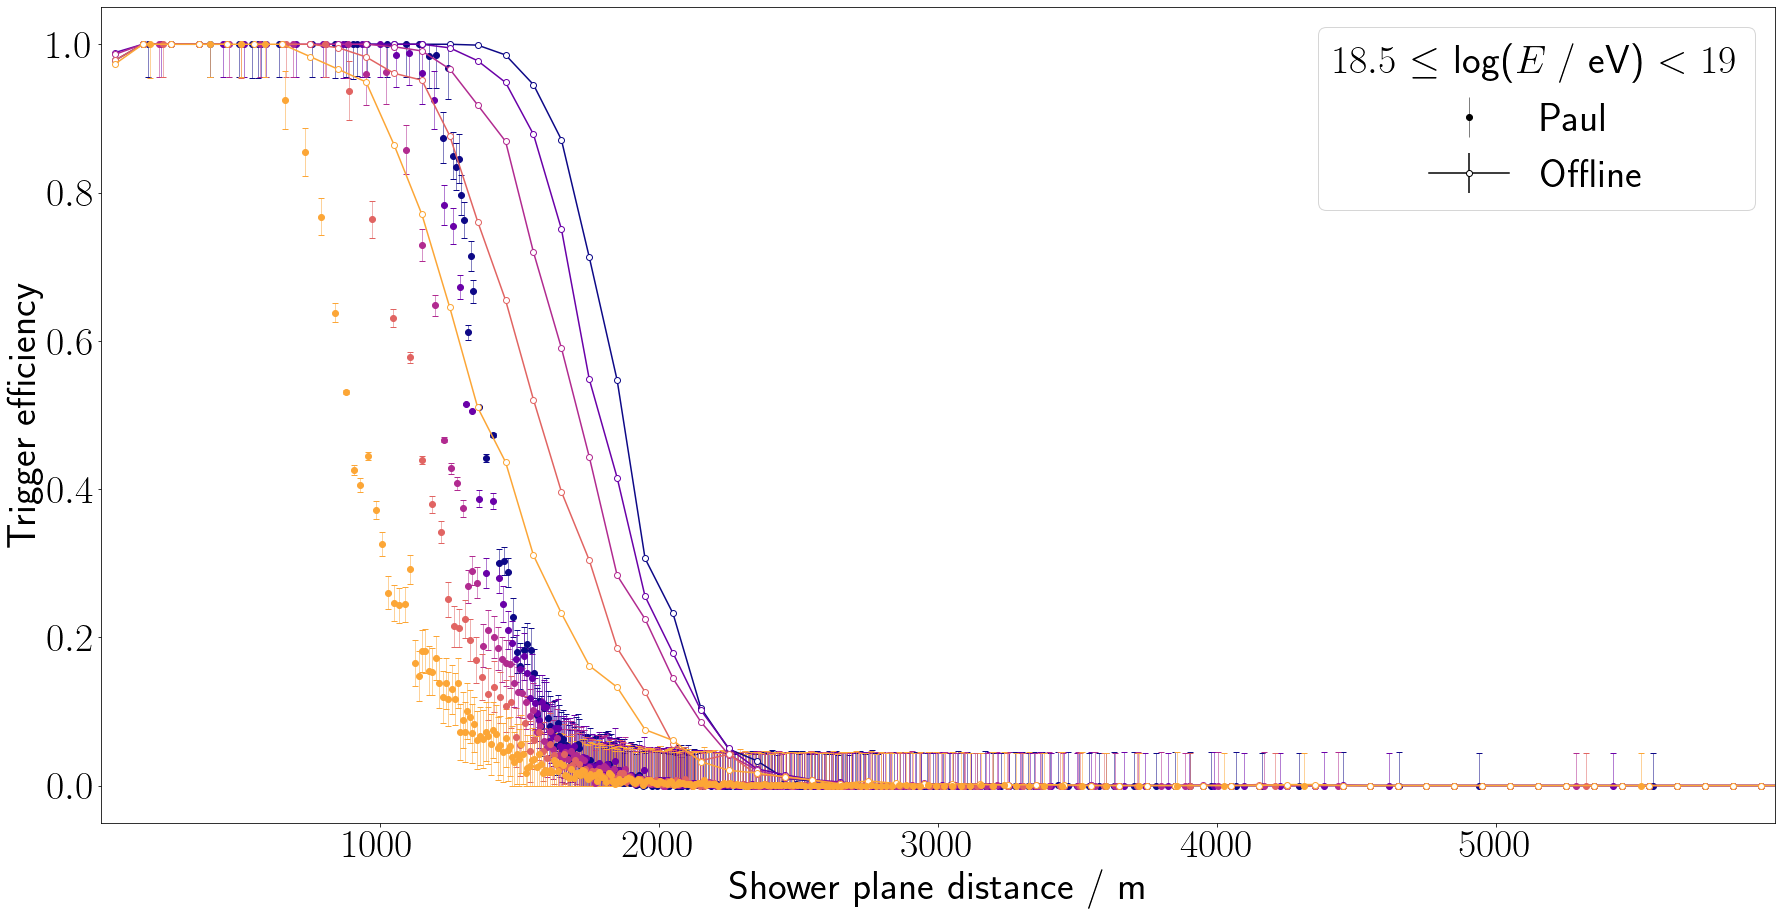

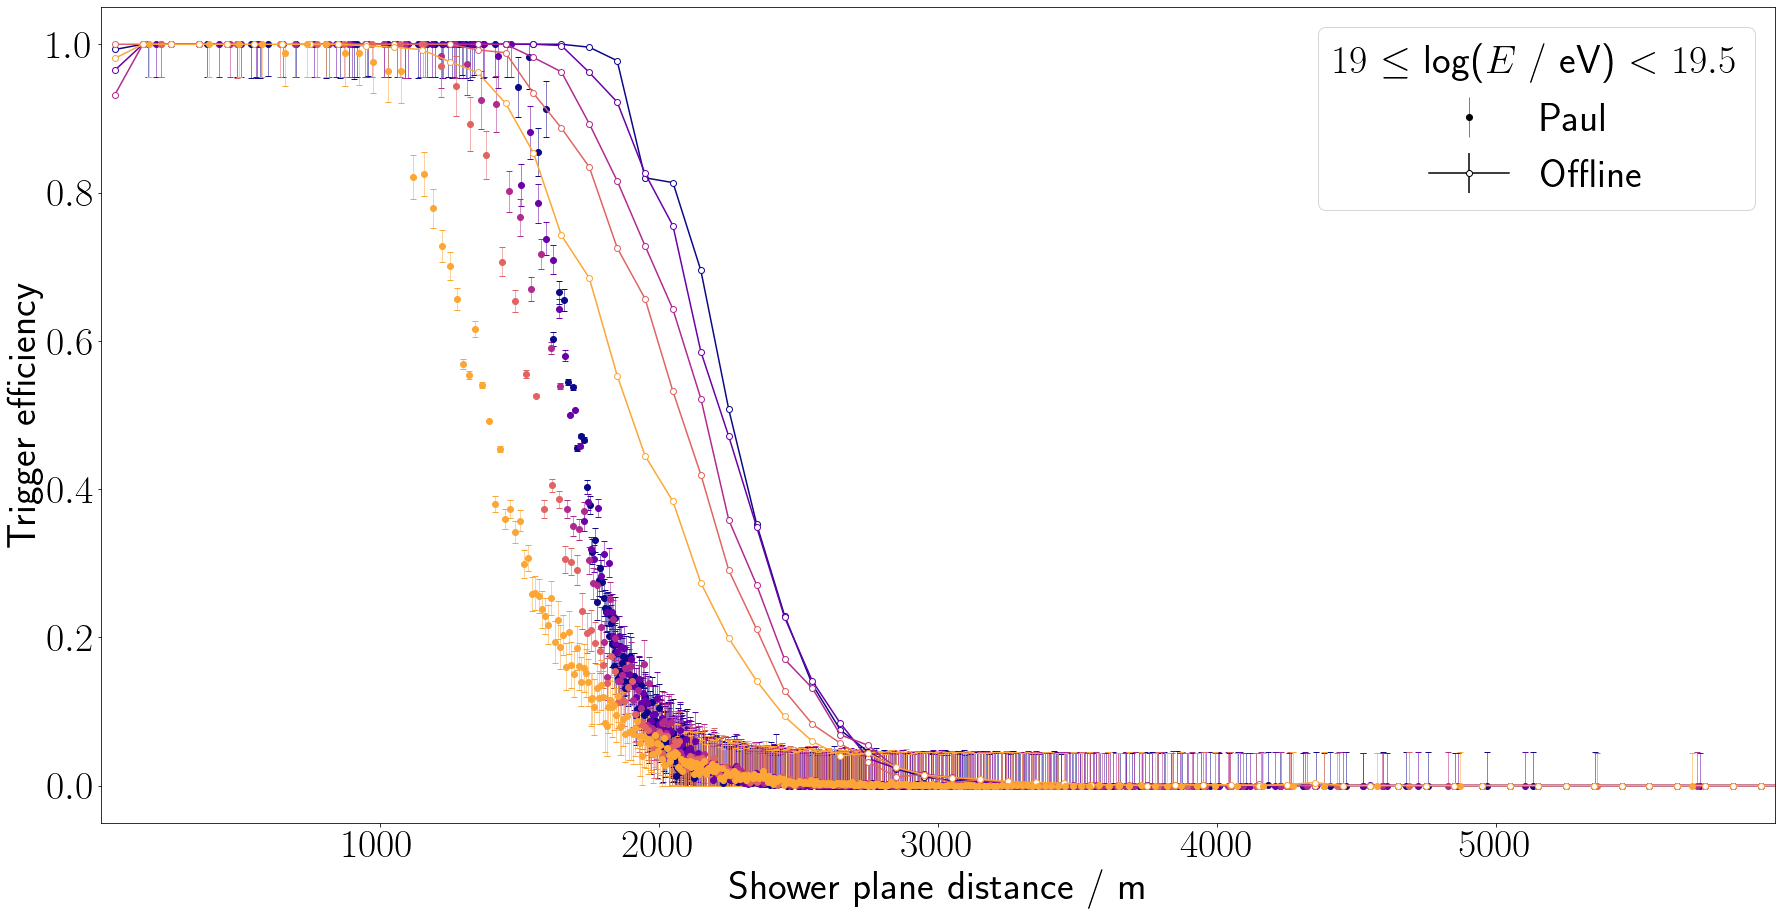

In [16]:
# My LTP
Trigger = HardwareClassifier()

c = lambda x, i : x.split("_")[i]
root_path = "/cr/tempdata01/filip/QGSJET-II/LTP/BINNED/"
checksum = lambda x : sum([10*float(c(x,0)), 10*float(c(x,1)), float(c(x,3))/10, float(c(x,4)[:-4])/10])
ldf_files = np.array(os.listdir(root_path))[np.argsort([checksum(file) for file in os.listdir(root_path )])]
ldf_files = [root_path + ldf_file for ldf_file in ldf_files]

TP, FP, TN, FN = Trigger.load_and_print_performance("full_random_traces_downsampled_vem_1.000")

warnings.simplefilter("ignore", RuntimeWarning)
colormap = cmap.get_cmap("plasma")
bar_kwargs = \
{
    "fmt" : "o",
    "elinewidth" : 0.5,
    "capsize" : 3
}

e_labels = [r"$16$", r"$16.5$", r"$17$", r"$17.5$", r"$18$", r"$18.5$", r"$19$", r"$19.5$"]            
annotate = lambda e : e_labels[e] + r" $\leq$ log($E$ / eV) $<$ " + e_labels[e + 1]

energy_bins = [10**16, 10**16.5, 10**17, 10**17.5, 10**18, 10**18.5, 10**19, 10**19.5]      # uniform in log(E)
theta_bins =  [0.0000, 33.5600, 44.4200, 51.3200, 56.2500, 65.3700]                         # pseudo-uniform in sec(θ)

miss_sorted = [[ [] for t in range(len(theta_bins) - 1) ] for e in range(len(energy_bins) - 1)]
hits_sorted = [[ [] for t in range(len(theta_bins) - 1) ] for e in range(len(energy_bins) - 1)]

# Sort predictions into bins of theta and energy
for source, target in zip([TP, FN], [hits_sorted, miss_sorted]):

    spd, energy, theta = source[:, 0], source[:, 1], source[:, 2]
    energy_sorted = np.digitize(energy, energy_bins)
    theta_sorted = np.digitize(theta, theta_bins)

    for e, t, shower_plane_distance in zip(energy_sorted, theta_sorted, spd):
        target[e - 1][t - 1].append(shower_plane_distance)

# Calculate efficiencies given sorted performances
# axis 1 = sorted by primary particles' energy
for e, (hits, misses) in enumerate(zip(hits_sorted, miss_sorted)):

    plt.figure()
    ax = plt.gca()

    ax.set_xlim(0, 6000)
    ax.set_xlabel("Shower plane distance / m")
    ax.set_xticks([1e3, 2e3, 3e3, 4e3, 5e3])
    ax.set_ylabel("Trigger efficiency")
    ax.set_ylim(-0.05, 1.05)

    ax.errorbar([],[], yerr = [], c = "k", **bar_kwargs, label = "Paul")
    ax.errorbar([],[], yerr = [], c = "k", mfc = "w", fmt = "-o", label = "Offline")
    ax.legend(loc = "upper right", title = annotate(e))

    # axis 2 = sorted by zenith angle
    for t, (hits, misses) in enumerate(zip(hits, misses)):

        c = colormap(t / (len(theta_bins) - 1))

        spd, x, o = np.loadtxt(ldf_files[e * 5 + t], unpack = True)
        err = np.clip(1/(x + o)**2 * np.sqrt( x**3 + o**3 - 2 * np.sqrt((x * o)**3) ), 1e-5, 1)
        ax.errorbar(spd - 50, x / (x + o), mfc = "w", color = c, fmt = "-o")

        LDF, (LDF_efficiency, LDF_prob_50, LDF_scale) = get_fit_function("/cr/tempdata01/filip/QGSJET-II/LDF/", e, t)

        all_data = hits + misses
        n_data_in_bins = 500

        # have at least 7 bins or bins with >50 samples
        while True:
            n_bins = len(all_data) // n_data_in_bins
            probabilities = np.linspace(0, 1, n_bins)
            binning = mquantiles(all_data, prob = probabilities)
            bin_center = 0.5 * (binning[1:] + binning[:-1])
            n_all, _ = np.histogram(all_data, bins = binning)

            if len(n_all) <= 7: 
                n_data_in_bins -= 10
                if n_data_in_bins == 50: break
            else: break

        x, _ = np.histogram(hits, bins = binning)
        o, _ = np.histogram(misses, bins = binning)
        efficiency = x / (x + o) * LDF(bin_center)
        efficiency_err = 1/n_all**2 * np.sqrt( x**3 + o**3 - 2 * np.sqrt((x * o)**3) )          # lack LDF error part here !!
        efficiency_err[efficiency_err == 0] = 1e-3                                              # such that residuals are finite

        upper = np.clip(efficiency + efficiency_err, 0, 1)
        lower = np.clip(efficiency - efficiency_err, 0, 1)

        ax.errorbar(bin_center, efficiency, yerr = [efficiency - lower, upper - efficiency], color = c, **bar_kwargs)

norm = BoundaryNorm(theta_bins, colormap.N)
ax2 = fig.add_axes([0.92, 0.1, 0.01, 0.8])
cbar = ColorbarBase(ax2, cmap=colormap, norm=norm, label = r"sec$(\theta)$ - 1")
cbar.set_ticks(theta_bins)
cbar.set_ticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.4"])

plt.subplots_adjust(hspace = 0.04, wspace = 0)

warnings.simplefilter("default", RuntimeWarning)